In [1]:
import os
import sys
from collections import defaultdict

# import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import patheffects
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon, Rectangle, FancyBboxPatch
from matplotlib.collections import PatchCollection

from seelab.visualize import get_labelme_annotations, rgb_to_rgba
from seelab.misc import AddDarkness, AddBrightness, AddRain, AddSnow

In [16]:
colors_map = {
    'gang form': rgb_to_rgba((30, 144, 255), 0.5),
    'person': rgb_to_rgba((0, 128, 0), 0.5),
    'support': rgb_to_rgba((138, 43, 226), 0.5),
    'hardhat': rgb_to_rgba((255, 255, 0), 0.5),
    'pallet': rgb_to_rgba((255, 95, 119), 0.5),
    'concrete pump truck': rgb_to_rgba((255, 0, 0), 0.5)
}

### Figure 1. Bounding box to polygon

In [23]:
image_file = './inputs/labelme/00000138.jpg'


def draw_plot1(ax, shapes):
    image = Image.open(image_file)
    ax.imshow(image)
    for shape in shapes['polygons']:
        if shape['label'] not in ['euro form', 'panel', 'support', 'iso pink', 'pallet', 'gunny sack']: 
            color = colors_map.get(shape['label'], ((0, 0, 0, 1), (0, 0, 0, 1)))
            polygon = Polygon(np.asarray(shape['points']), True, fc=color[0], ec=color[1])
            ax.add_patch(polygon)

    ax.axis('off')


def draw_plot2(ax, shapes):
    image = Image.open(image_file)
    # left, upper, right, and lower
    coord = (1680, 300, 1797, 423)
    image = image.crop(coord)
    ax.imshow(image, alpha=0.1)

    for shape in shapes['polygons']:
        if shape['label'] == 'person': 
            points = np.asarray(shape['points'])
            if np.max(points[:,0]) > 1680:
                polygon = points

    polygon[:, 0] = polygon[:, 0] - 1680
    polygon[:, 1] = polygon[:, 1] - 300

    color = colors_map.get('person', 1)
    patches = Polygon(np.asarray(polygon), True, fc=color[0], ec=color[1])
    ax.add_patch(patches)
    
    xs = []
    ys = []
    for p in polygon:
        xs.append(p[0])
        ys.append(p[1])

    x_min, x_max = np.min(polygon[:, 0]), np.max(polygon[:, 0]-17)
    y_min, y_max = np.min(polygon[:, 1]), np.max(polygon[:, 1]-9)

    box = [x_min, y_min, x_max, y_max]

    line = Line2D(
        np.asarray(polygon)[:, 0], np.asarray(polygon)[:, 1], 
        linewidth=0.5, color='black', markersize=3., marker='o', markeredgecolor='none', markeredgewidth=.5)#markeredgecolor='r')
    ax.add_line(line)

    rectangles = FancyBboxPatch((box[0], box[1]), box[2], box[3], fc=color[0], ec=color[1], boxstyle='square,pad=0.')
    ax.add_patch(rectangles)

    boxes = [
        [box[0], box[1]],
        [box[0]+box[2], box[1]],
        [box[0], box[1]+box[3]],
        [box[0]+box[2], box[1]+box[3]]
    ]

    texts = ['(min x, min y)', '(max x, min y)', '(min x, max y)', '(max x, max y)']
    va = 'bottom'
    offset = -1.5
    for i, (box, text) in enumerate(zip(boxes, texts)):
        ax.scatter(box[0], box[1], c='g', s=10,)# ec='w', lw=0.5)
        if i > 1:
            va = 'top'
            offset = 1.5
        
        # path_effects=[patheffects.withStroke(linewidth=.9, foreground='gray')])
        # bbox=dict(facecolor='r', edgecolor='r', pad=0.0))
        ax.annotate(
            text, (box[0], box[1]+offset), color='black', weight='bold', 
            fontsize=7, ha='center', va=va)

    ax.annotate(
        'Polygon to bound', (80, 60),  xytext=(70, 85), color='black', weight='bold', 
        fontsize=7, ha='left', va='top', arrowprops={'arrowstyle': '->'})
    ax.annotate(
        'Bounding box', (40, 8),  xytext=(2, 20), color='black', weight='bold', 
        fontsize=7, ha='left', va='top', arrowprops={'arrowstyle': '->'})
    ax.axis('off')


def draw_plot3(ax, shapes):
    image = Image.open(image_file)
    ax.imshow(image)
    for shape in shapes['boxes']:
        if shape['label'] in ['person']:
            box = shape['points']
            color = color = colors_map.get(shape['label'], ((0, 0, 0, 1), (0, 0, 0, 1)))
            rectangle = Rectangle((box[0], box[1]), box[2], box[3], fc=color[0], ec=color[1])
            ax.add_patch(rectangle)
            
            ax.annotate(
                shape['label'], (box[0], box[1]), color='w', weight='bold', 
                fontsize=3, ha='left', va='bottom', 
                bbox=dict(facecolor=color[1], edgecolor=color[1], pad=0.0))

    ax.axis('off')

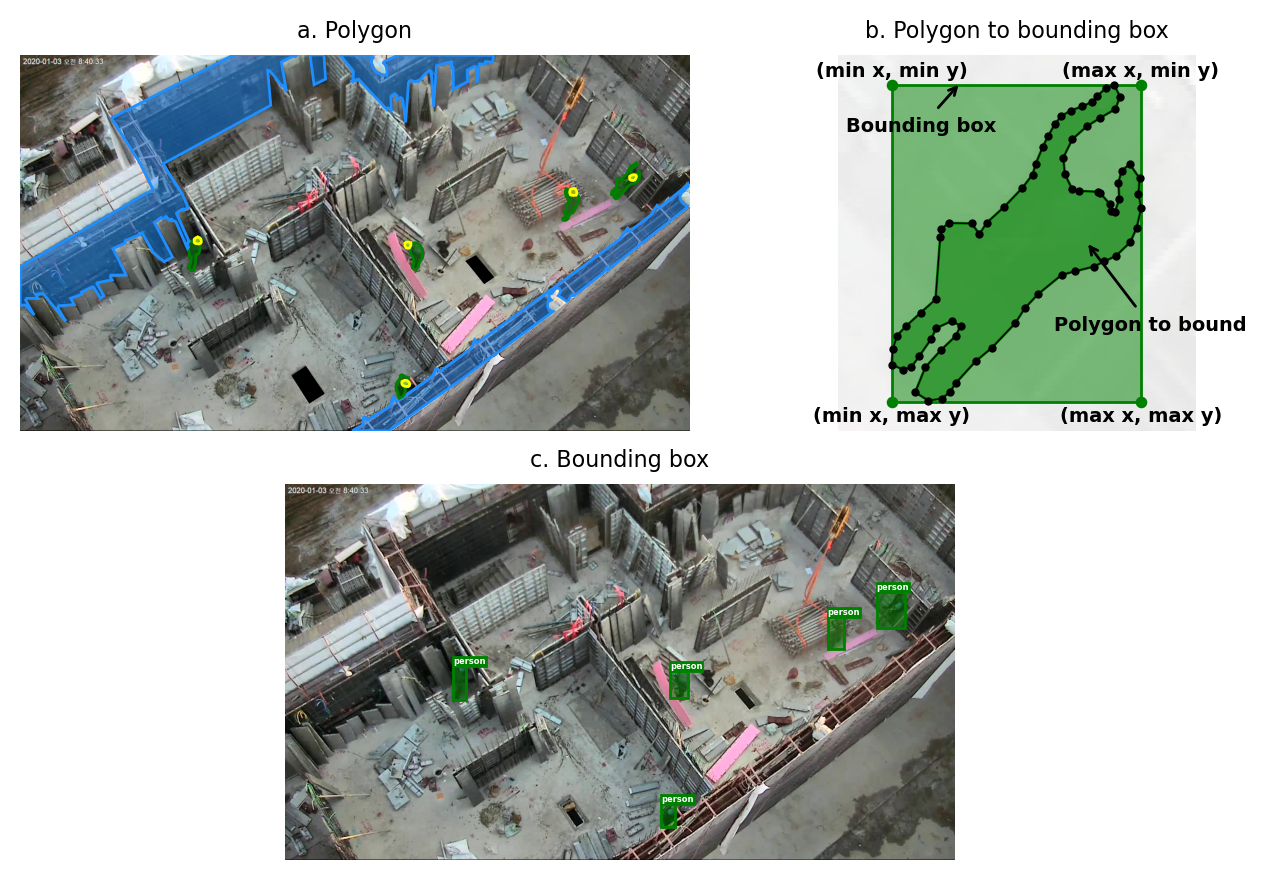

In [24]:
shapes = get_labelme_annotations('./inputs/labelme/00000138.json', xywh=True)

fig = plt.figure(figsize=(7,4.5), dpi=200)
gs = fig.add_gridspec(2, 5)

ax1 = fig.add_subplot(gs[0, :3])
draw_plot1(ax1, shapes)
ax1.set_title('a. Polygon', fontsize=8)

ax2 = fig.add_subplot(gs[0, 3:])
draw_plot2(ax2, shapes)
ax2.set_title('b. Polygon to bounding box', fontsize=8)

ax3 = fig.add_subplot(gs[1, 1:4])
draw_plot3(ax3, shapes)
ax3.set_title('c. Bounding box', fontsize=8)
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.14)
plt.show()
# fig.savefig('./outputs/fig-0001.png', bbox_inches='tight')  # pad_inches

### Figure 2. Example of rainy affect surveillance camera lens

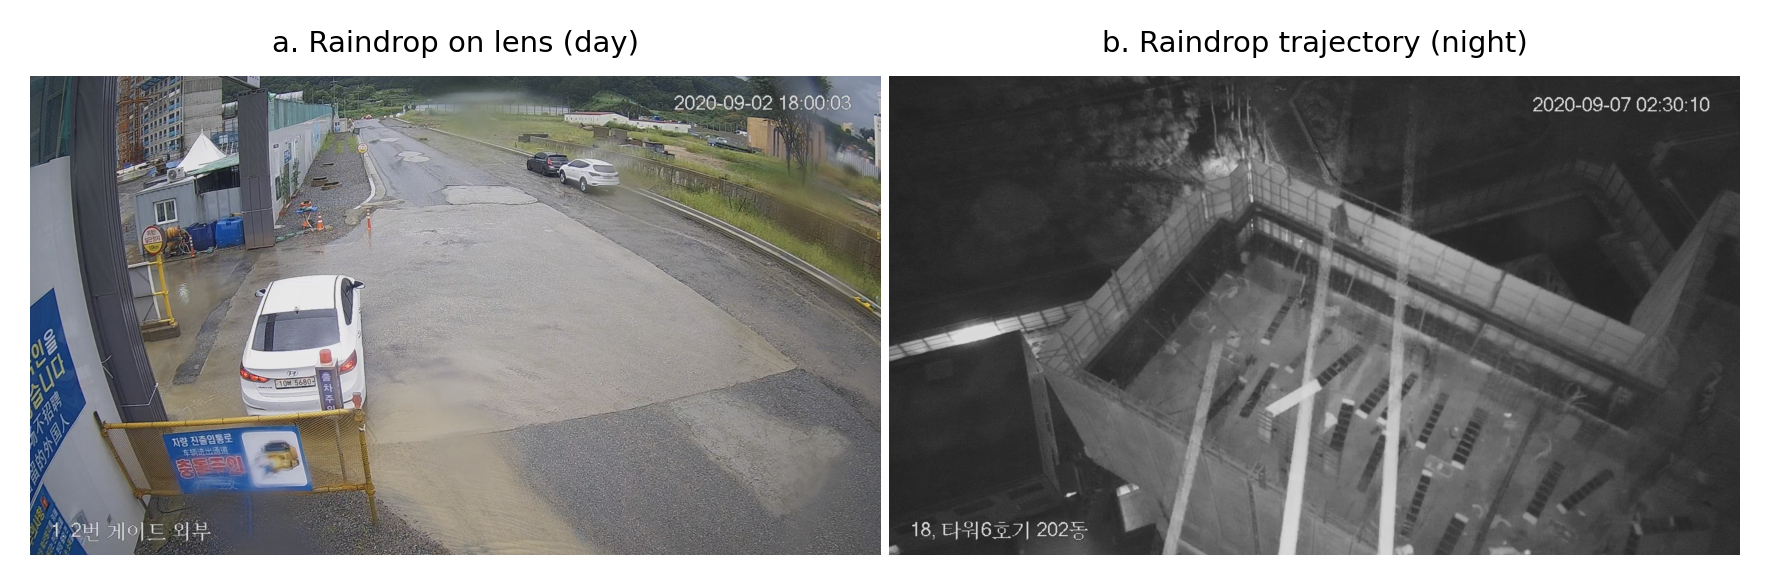

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

image = Image.open('./inputs/images/0002.png').convert('RGB')
image = image.resize((1920, 1080))
ax1.imshow(image)
ax1.axis('off')

image = Image.open('./inputs/images/0001.png').convert('RGB')
image = image.resize((1920, 1080))
ax2.imshow(image)
ax2.axis('off')

ax1.set_title('a. Raindrop on lens (day)', fontsize=7)
ax2.set_title('b. Raindrop trajectory (night)', fontsize=7)
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()                        
# fig.savefig('./outputs/fig-0002.png', bbox_inches='tight') # pad_inches

### Figure 3. Compare original image and applying weather augmentation

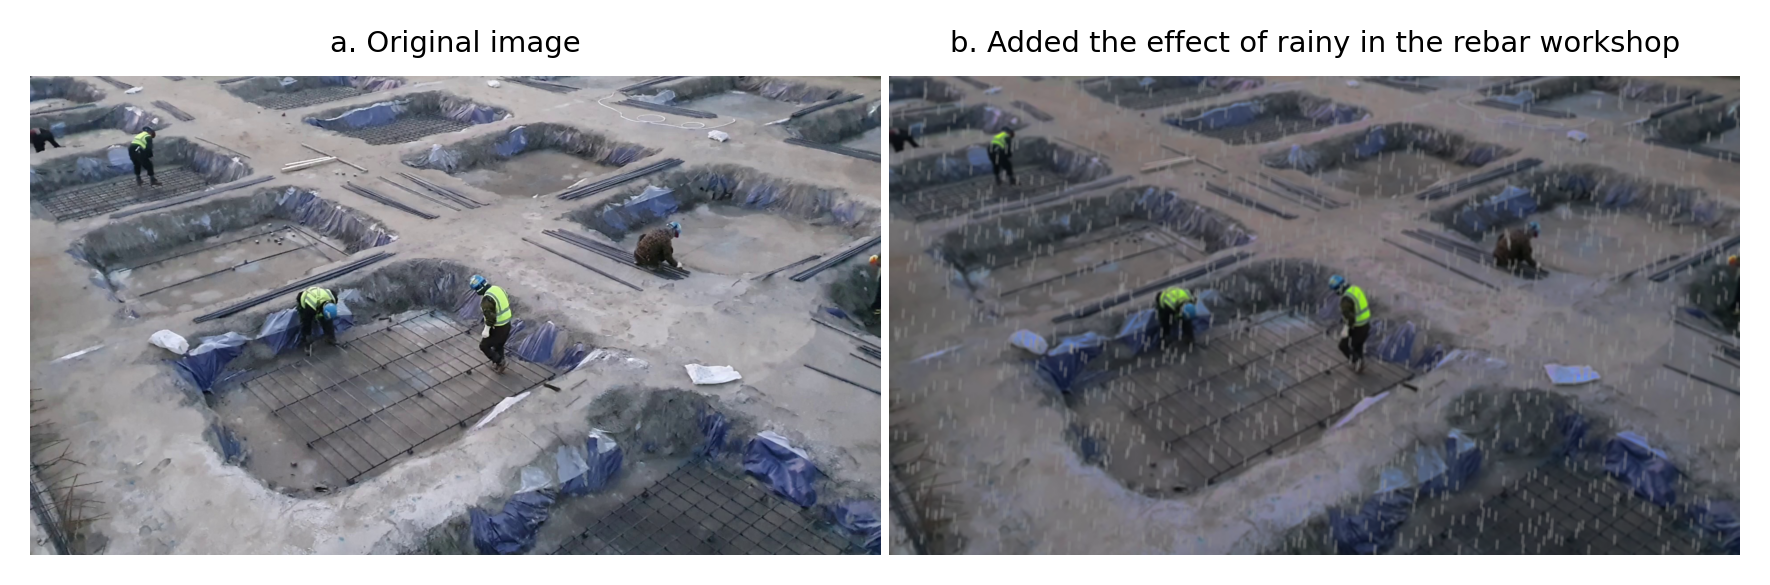

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

image = Image.open('./inputs/labelme/10000250.jpg').convert('RGB')
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('a. Original image', fontsize=7)

outputs = AddRain()(image)
ax2.imshow(outputs[0])
ax2.axis('off')
ax2.set_title('b. Added the effect of rainy in the rebar workshop', fontsize=7)

fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()
# fig.savefig('./outputs/fig-0003.png', bbox_inches='tight') # pad_inches

### Figure 6. Our results between instance segmentation

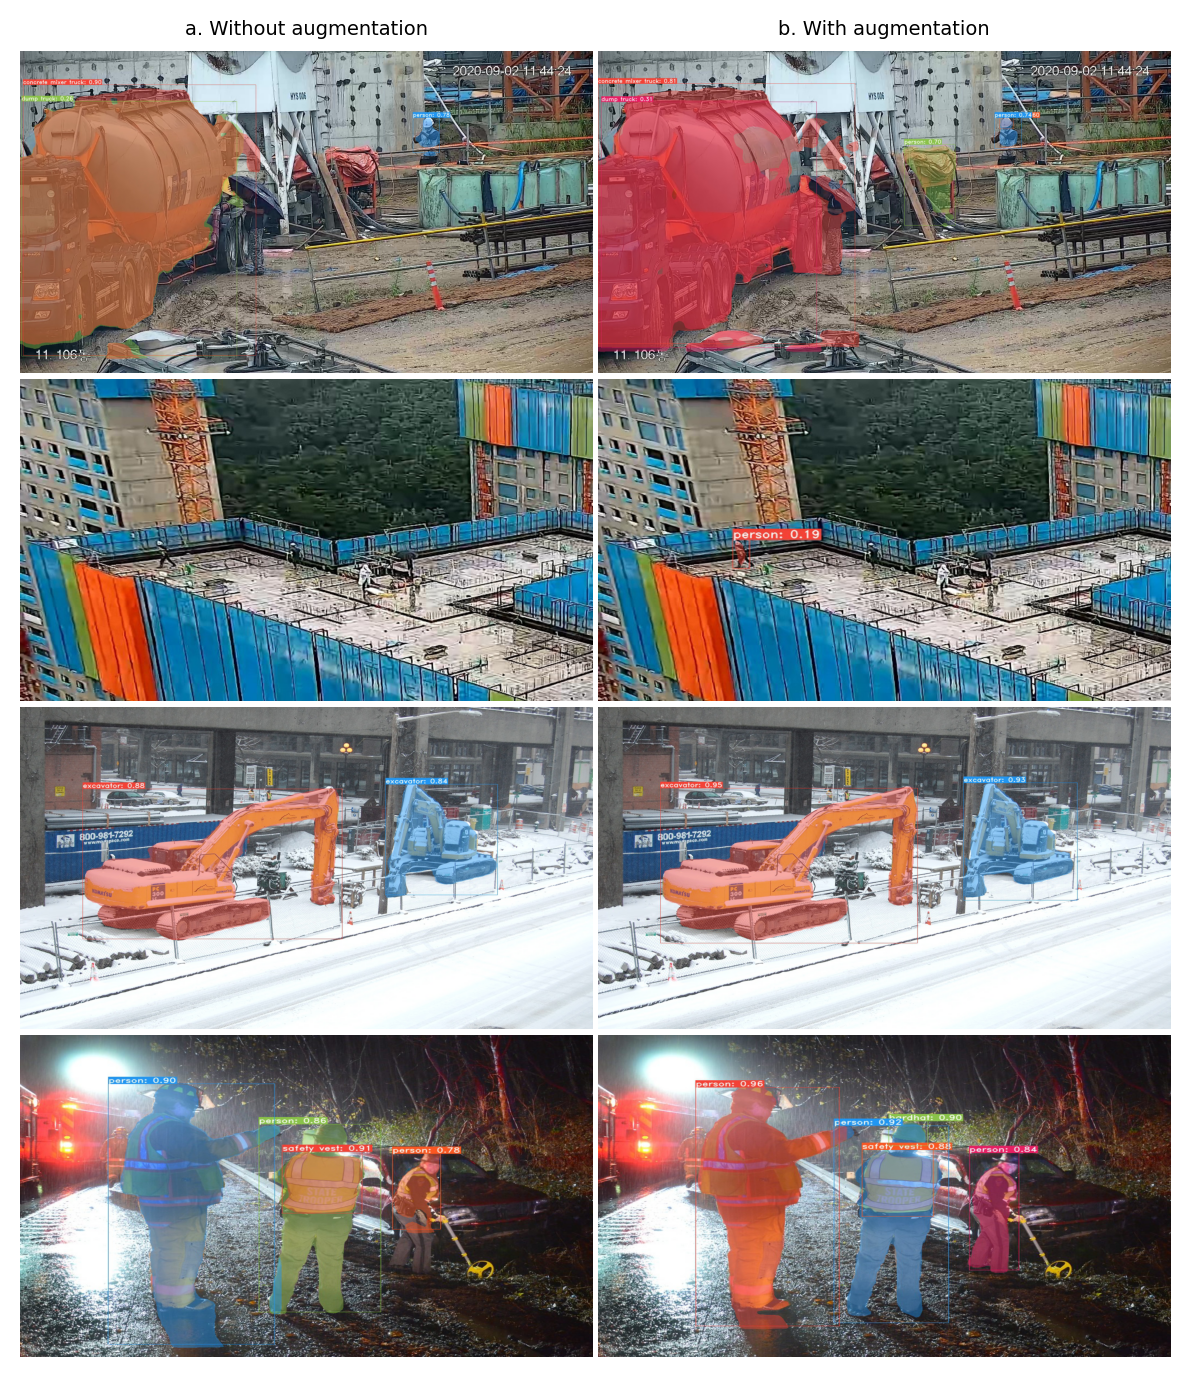

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(6.05, 7), dpi=200)
images = [
    '0202-1.jpg', '0202-2.jpg',
    '0205-1.jpg', '0205-2.jpg',
    '0102-1.jpg', '0102-2.jpg',
    '0132-1.jpg', '0132-2.jpg']

for i, path in enumerate(images):
    image = Image.open(f'./inputs/images/{path}').convert('RGB')
    image = image.resize((1920, 1080))
    axes.flat[i].imshow(image)
    axes.flat[i].axis('off')

axes.flat[0].set_title('a. Without augmentation', fontsize=7)
axes.flat[1].set_title('b. With augmentation', fontsize=7)
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()
# fig.savefig('./outputs/fig-0006.png', bbox_inches='tight') # pad_inches